In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize': (40, 15)}, font_scale=1.5)

df = pd.read_csv('/content/drive/MyDrive/ECH_2019.csv')



In [3]:
df.sample(5)

,id_hogar,sexo,edad,ascendencia,parentesco,estado_laboral,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof
96874,2019052156,Mujer,25,Blanca,Hijo/a solo del jefe/a,Ocupados,1600,Sí,Actividades de los hogares en calidad de emple...,Sí,"Sí, asistió","Sí, asistió","Sí, asistió","Sí, asistió",0,0,0,0
99176,2019053405,Hombre,20,Blanca,Hermano/a,Ocupados,17000,No,Actividades de defensa,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,0,0,0,0
35391,2019019061,Hombre,51,Blanca,Jefe/a de hogar,Ocupados,0,No,Cría de ganado vacuno y búfalos,Sí,No asistió,"Sí, asistió","Sí, asistió",No asistió,0,0,0,0
22460,2019012167,Mujer,9,Blanca,Hijo/a solo del jefe/a,Menores de 14 años,0,0,.,Sí,"Sí, asistió",Asiste actualmente,0,0,0,0,0,0
100237,2019053987,Hombre,31,Blanca,Jefe/a de hogar,Ocupados,22000,No,Cría de ganado vacuno y búfalos,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,0,0,0,0


In [4]:
no_data = {0: 'No hay dato', '0': 'No hay dato'}

mask = df.columns.difference(['edad', 'sueldo', 'hijos'])

df[mask] = df[mask].replace(no_data)

df.sample(5)



,id_hogar,sexo,edad,ascendencia,parentesco,estado_laboral,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof
36326,2019019556,Mujer,32,Blanca,Jefe/a de hogar,Ocupados,0,No,Elaboración de productos de panadería,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,No hay dato,No hay dato,No hay dato,No hay dato
77060,2019041605,Hombre,20,Blanca,Hijo/a solo del jefe/a,Ocupados,30000,No,Construcción de infraestructura de transporte,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,No hay dato,No hay dato,No hay dato,No hay dato
29861,2019016082,Mujer,63,Blanca,Esposo/a o compañero/a,Ocupados,12000,No,Otros tipos de intermediación monetaria,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,No hay dato,No hay dato,No hay dato,No hay dato
43819,2019023513,Hombre,23,Blanca,Hijo/a de ambos,Inactivo: pensionista,0,No hay dato,.,Sí,"Sí, asistió","Sí, asistió",No hay dato,No asistió,No hay dato,No hay dato,No hay dato,No hay dato
38057,2019020467,Hombre,29,Blanca,Esposo/a o compañero/a,Ocupados,35000,No,Actividades de apoyo a la agricultura,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,No asistió,No asistió,No hay dato,No asistió


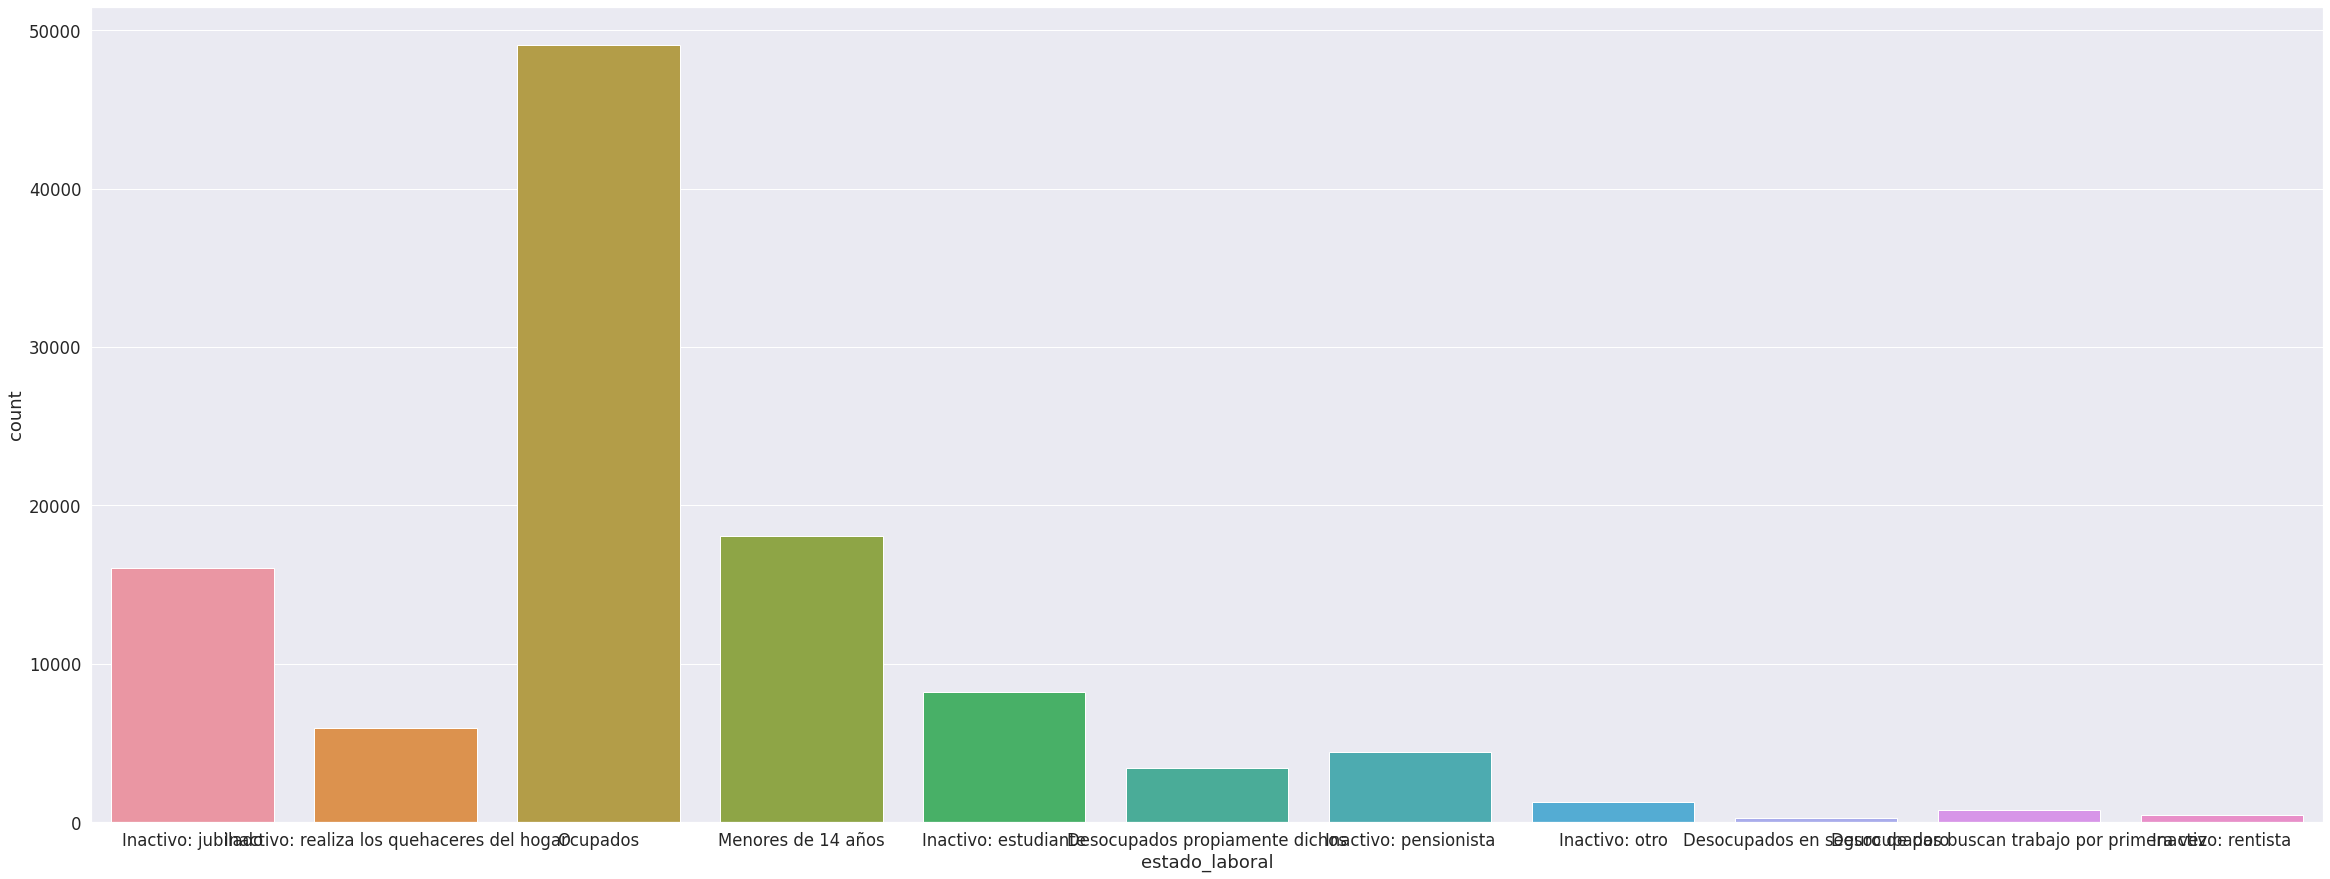

In [5]:
sns.countplot(x=df['estado_laboral'])



Seleccionamos personas con edad suficiente para trabajar

In [6]:
# df = df[~df['estado_laboral'].str.contains('Menores de 14 años')]



Codificamos los valores de parentezco

Creamos una columna que cuenta la cantidad de hijos por grupo familiar

In [7]:
df['hijos'] = (
    df.groupby('id_hogar')['id_hogar'].transform('count') - 1
)



# CATEGORIZAR NUMERICOS

In [8]:
df['rango_sueldos'] = pd.cut(df['sueldo'], bins=[
    0,
    5000,
    10000,
    30000,
    50000,
    100000,
    float('Inf'),
    ]).astype('category')

df['rango_edades'] = pd.cut(df['edad'], bins=[
    0,
    10,
    15,
    20,
    30,
    40,
    50,
    60,
    70,
    float('Inf'),
    ]).astype('category')

# labels=['0-5000', 'yyy', 'zzz']



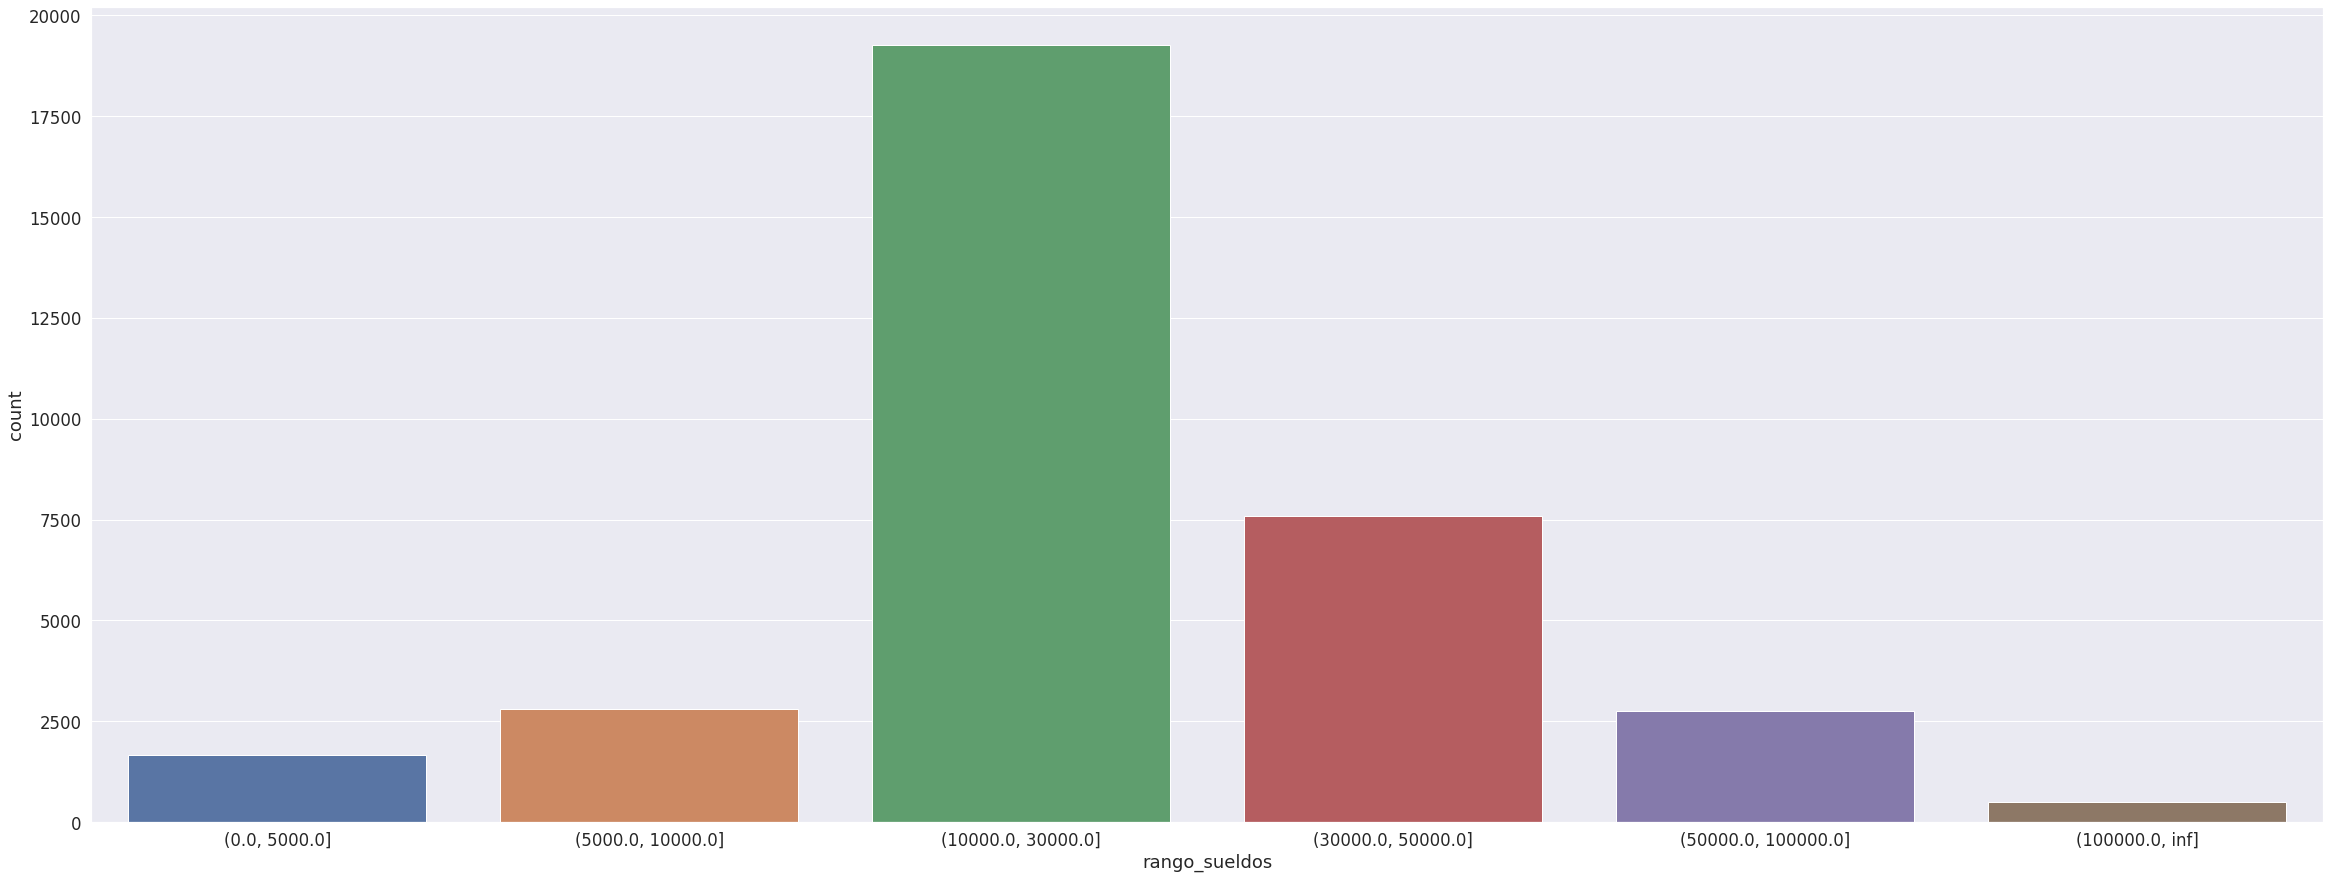

In [9]:
sns.countplot(x=df['rango_sueldos'])



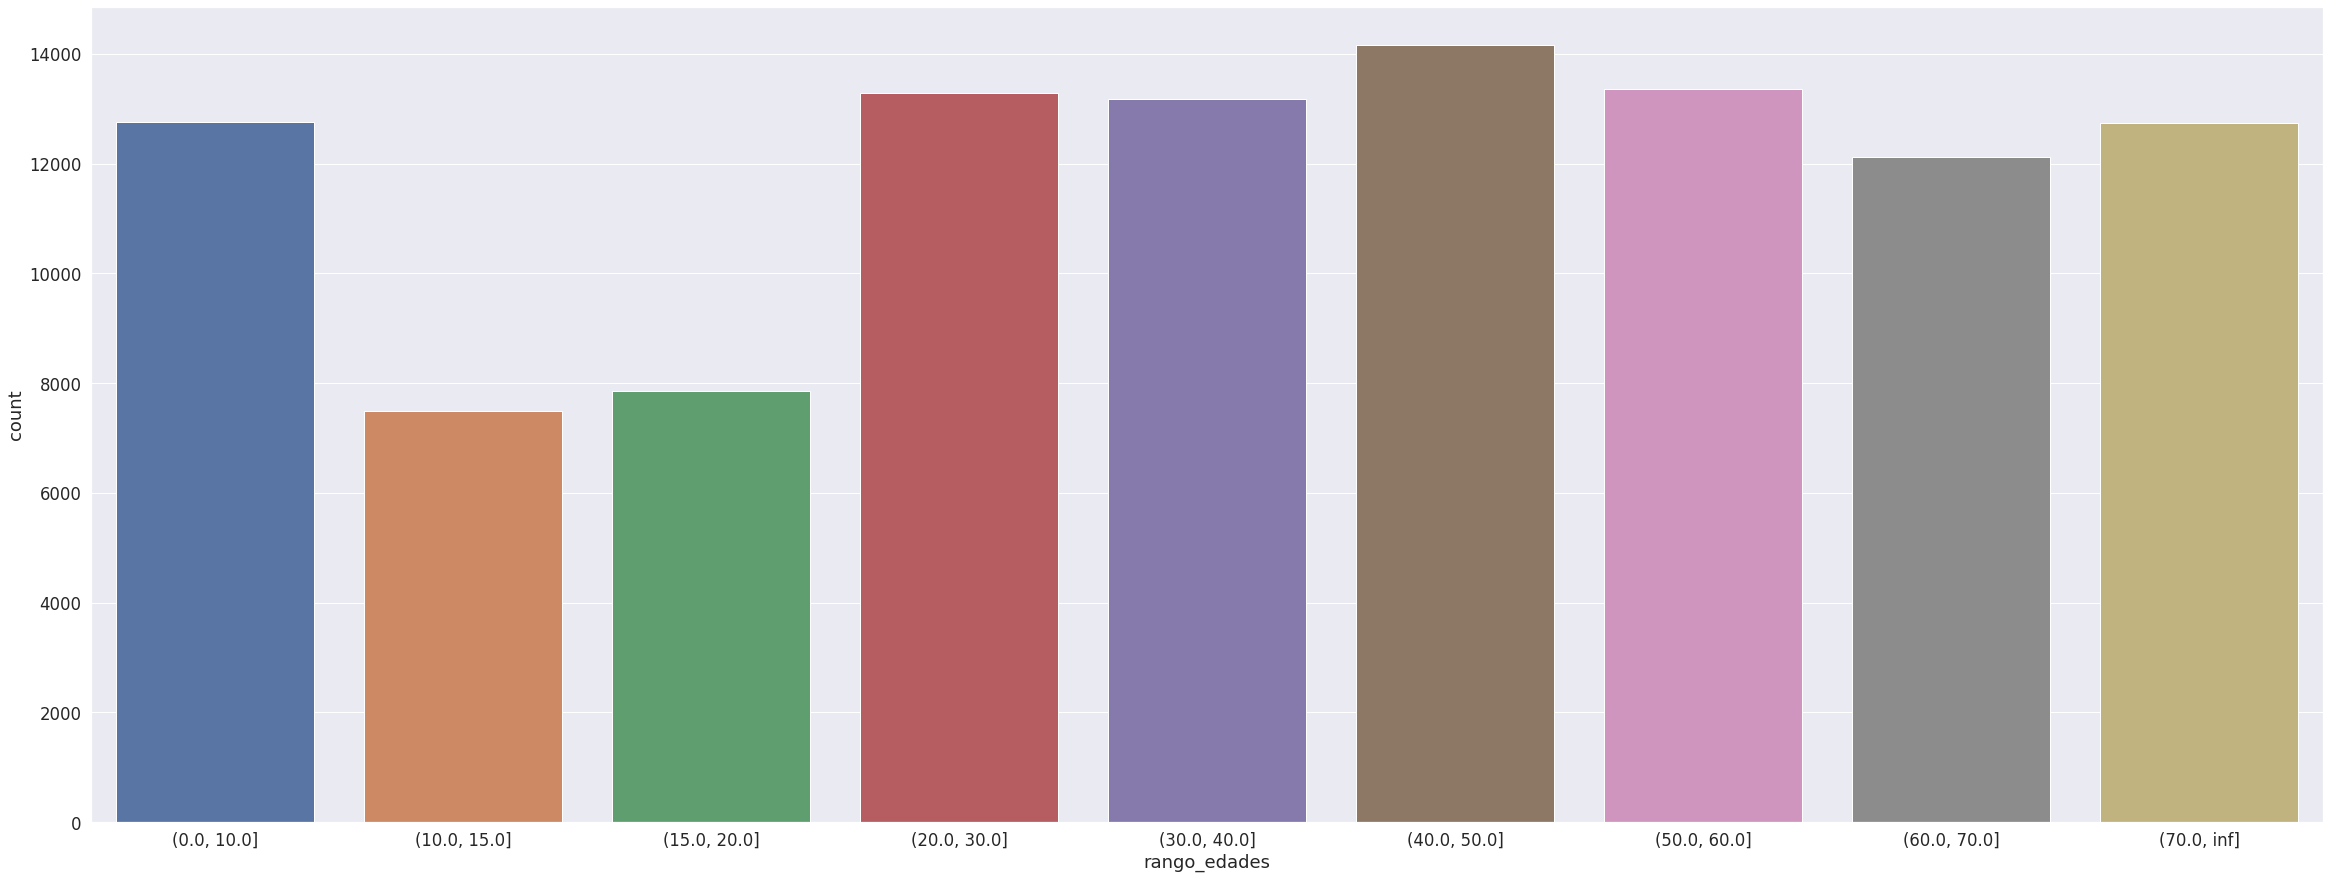

In [10]:
sns.countplot(x=df['rango_edades'])



### AJUSTANDO DATOS PARA ENTRENAR EL MODELO

Primero encodificamos las variables categóricas

Eliminanos las columnas que no vamos a usar o que ya categorizamos

In [11]:
df.columns



Index(['id_hogar', 'sexo', 'edad', 'ascendencia', 'parentesco',
       'estado_laboral', 'sueldo', 'busca_otro_trabajo', 'actividad',
       'asistencia alguna vez a enseñanza', 'edu preescolar', 'edu primaria',
       'edu media', 'edu técnica', 'edu univ o simil', 'edu terciario no uni',
       'edu posgrado', 'edu mag prof', 'hijos', 'rango_sueldos',
       'rango_edades'],
      dtype='object')

In [12]:
df = df[[
    'sexo',
    'ascendencia',
    'estado_laboral',
    'busca_otro_trabajo',
    'actividad',
    'asistencia alguna vez a enseñanza',
    'edu preescolar',
    'edu primaria',
    'edu media',
    'edu técnica',
    'edu univ o simil',
    'edu terciario no uni',
    'edu posgrado',
    'edu mag prof',
    'parentesco',
    'hijos',
    'rango_sueldos',
    'rango_edades',
    ]]



### DEFINIMOS LAS VARIABLES DEPENDIENTES E INDEPENDIENTES

In [13]:
# Feautures
X = df.drop('estado_laboral', axis=1).to_numpy()
y = df['estado_laboral']

print('X shape', X.shape, '\nY shape', y.shape)



X shape (107871, 17) 
Y shape (107871,)


In [14]:
np.unique(y)



array(['Desocupados buscan trabajo por primera vez',
       'Desocupados en seguro de paro', 'Desocupados propiamente dichos',
       'Inactivo: estudiante', 'Inactivo: jubilado', 'Inactivo: otro',
       'Inactivo: pensionista',
       'Inactivo: realiza los quehaceres del hogar', 'Inactivo: rentista',
       'Menores de 14 años', 'Ocupados'], dtype=object)

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()

X = one_hot.fit_transform(X)


In [16]:
one_hot.categories_

[array(['Hombre', 'Mujer'], dtype=object),
 array(['Afro o negra', 'Asiática o amarilla', 'Blanca', 'Indígena',
        'No hay dato', 'Otra'], dtype=object),
 array(['No', 'No hay dato', 'Sí'], dtype=object),
 array(['   .', 'Abastecimiento de eventos',
        'Acabado de productos textiles',
        'Actividades combinadas de apoyo a instalaciones',
        'Actividades de Museos y preservación de lugares históricos',
        'Actividades de administración de empresas y de consultoría',
        'Actividades de administración de fondos',
        'Actividades de agencias de cobranza y oficinas de crédito',
        'Actividades de agencias de colocación de empleados',
        'Actividades de agencias de noticias',
        'Actividades de agencias de trabajo temporal',
        'Actividades de agencias de viajes',
        'Actividades de alojamiento de corto plazo',
        'Actividades de alojamiento en albergues',
        'Actividades de alojamiento en hoteles',
        'Actividades de

### Dividimos los datos en un 30% de test y 70% de entrenamiento

In [17]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 



In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(75509, 477) (75509,)
(32362, 477) (32362,)


### DEFINIMOS ALGORITMO DE REGRESIÓN LOGISTICA Y VALOR DE CROSS VALIDATION PARA CADA FOLD

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=20000)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

scores = cross_val_score(clf, X, y, cv=10)

scores



array([0.88060808, 0.88068972, 0.88152406, 0.878094  , 0.88087513,
       0.88393437, 0.88189487, 0.88004079, 0.88050431, 0.88133865])

Promedio de scores en el Cross Validation

In [20]:
scores.mean()



0.8809503976260029

Scores de cada clasificación

In [21]:
clf.score(X_test, y_test)



0.8827946356838267

In [22]:
clf.score(X_train, y_train)



0.8818286561866797

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))



[[    7     0    33   109     0    47     1    32     0     0     0]
 [    1     0    29     7     8     1     0    23     0     0     0]
 [    3     0   342   159    91    53     9   334     1     0     0]
 [    0     0    27  2073     3     0     2     0     0   425     0]
 [    0     0    19     1  4494     2    95   127     0     0     0]
 [   19     0   110     0    64   112    18    77     0     4     0]
 [    0     0    41    21   854    18   229   127     0    13     0]
 [    5     0   111     0   426    32    41  1157     0     1     0]
 [    0     0    10     2    82     0     3    40     0     0     0]
 [    0     0     0    31     0     1     0     0     0  5383     0]
 [    0     0     0     0     0     0     0     0     0     0 14772]]


### INVESTIGAMOS LA EFECTIVIDAD DEL MODELO SOBRE LOS DATOS

In [24]:
from sklearn.metrics import accuracy_score

#Prediccion en Train
y_train_pred = clf.predict(X_train)

#Prediccion en Test
y_test_pred = clf.predict(X_test)

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)



% de aciertos sobre el set de entrenamiento: 0.8818286561866797
% de aciertos sobre el set de evaluación: 0.8827946356838267


### DEFINIMOS UNA PREDICCIÓN Y LA APLICAMOS SOBRE EL MODELO

In [25]:
prediction = X.toarray()

prediction = prediction[1000].reshape(1, -1)
print(clf.predict(prediction))
print(y_train[1000])


['Inactivo: estudiante']
Inactivo: estudiante


Determinamos la probabilidad de la predicción

In [26]:
probabilidades_prediccion = clf.predict_proba(prediction)
probabilidades_prediccion[:,1]

array([0.02261323])